In [185]:
# [数据处理](https://www.kaggle.com/startupsci/titanic-data-science-solutions)
# 使用的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve
import random
random.seed(0)

# 模型
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier


In [186]:
# 导入训练和测试数据
train_data = pd.read_csv('../data/titanic/train.csv',encoding='utf-8',iterator=False)
test_data = pd.read_csv('../data/titanic/test.csv',encoding='utf-8',iterator=False)

# 组合数据
combine = [train_data,test_data]

In [187]:
# 查看数据概况
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [188]:
# 缺失值统计
def get_missing_data_info(data):
    """
    获取缺失值统计
     Parameters
    ----------
    data : Series or DataFrame
        要统计的数据

    Returns
    -------
    Series or DataFrame
        统计总数和占比
    """
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    

In [189]:
# 查看缺失值
print("train_data:",get_missing_data_info(train_data).head(5))
print("-"*40)
print("test_data:",get_missing_data_info(test_data).head(5))

train_data:           Total   Percent
Cabin       687  0.771044
Age         177  0.198653
Embarked      2  0.002245
Fare          0  0.000000
Ticket        0  0.000000
----------------------------------------
test_data:           Total   Percent
Cabin       327  0.782297
Age          86  0.205742
Fare          1  0.002392
Embarked      0  0.000000
Ticket        0  0.000000


In [190]:
# 分析缺失值
# Cabin 的缺失值达到了70%以上,删除
# Age 的缺失值可以通过中位数的填充
# Embarked,Fare 的缺失值可以通过最高频率值来填充

fill_age = train_data['Age'].median()
fill_embarked = train_data['Embarked'].value_counts().index[0]
fill_fare = train_data['Fare'].median()

for dataset in combine:
    dataset['Age'].fillna(fill_age,inplace=True)
    dataset['Embarked'].fillna(fill_embarked,inplace=True)
    dataset['Fare'].fillna(fill_fare,inplace=True)

In [191]:
# 特征工程
# 1. 年龄分段
# 2. 是否单独
# 3. 票价分段
# 4. 姓名


            AgeBand  Survived
0    (0.34, 16.336]  0.550000
1  (16.336, 32.252]  0.344168
2  (32.252, 48.168]  0.404255
3  (48.168, 64.084]  0.434783
4    (64.084, 80.0]  0.090909


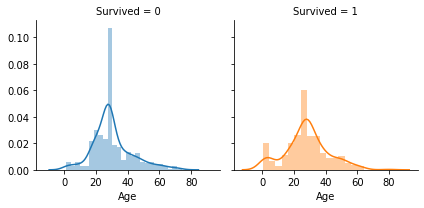

In [192]:
train_copy = train_data.copy()
g = sns.FacetGrid(data=train_copy,col='Survived',hue='Survived')
g = g.map(sns.distplot,'Age')
# 年龄区间划分(0,10]<(10,60]<(60,]
train_copy['AgeBand'] = pd.cut(train_copy['Age'],5)
age_band = train_copy[['AgeBand','Survived']].groupby('AgeBand',as_index=False).mean().sort_values(by='AgeBand',ascending=True)
print(age_band)

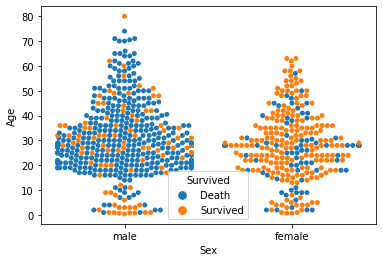

In [193]:
survived_map = {1:"Survived", 0:"Death"}

sns.swarmplot(x="Sex", y="Age", 
              hue=train_data["Survived"].map(survived_map).copy(), 
              data=train_data)

In [194]:
# 根据家庭数量,判断是否单独
train_copy['FamilySize'] = train_copy['SibSp'] + train_copy['Parch'] + 1
family_size = train_copy[['FamilySize','Survived']].groupby('FamilySize',as_index=False).mean().sort_values(by='Survived',ascending=False)
print(family_size)

   FamilySize  Survived
3           4  0.724138
2           3  0.578431
1           2  0.552795
6           7  0.333333
0           1  0.303538
4           5  0.200000
5           6  0.136364
7           8  0.000000
8          11  0.000000


In [195]:
# 票价
train_copy['FareBand'] = pd.qcut(train_copy['Fare'],4)
fare_band = train_copy[['FareBand','Survived']].groupby('FareBand',as_index=False).mean().sort_values(by='FareBand',ascending=True)
print(fare_band)

          FareBand  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


In [196]:
train_copy.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBand,FamilySize,FareBand
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,"(16.336, 32.252]",2,"(-0.001, 7.91]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,"(32.252, 48.168]",2,"(31.0, 512.329]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,"(16.336, 32.252]",1,"(7.91, 14.454]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,"(32.252, 48.168]",2,"(31.0, 512.329]"
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,"(32.252, 48.168]",1,"(7.91, 14.454]"
5,6,0,3,"Moran, Mr. James",male,28.0,0,0,330877,8.4583,NaN,Q,"(16.336, 32.252]",1,"(7.91, 14.454]"
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,"(48.168, 64.084]",1,"(31.0, 512.329]"
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,"(0.34, 16.336]",5,"(14.454, 31.0]"
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,"(16.336, 32.252]",3,"(7.91, 14.454]"
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,"(0.34, 16.336]",2,"(14.454, 31.0]"


In [197]:
# [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
train_copy['Title'] = train_copy['Name'].str.extract(' ([A-Za-z]+)\.',expand=False)
pd.crosstab(train_copy['Title'], train_copy['Sex'])


Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [198]:
# 数据特征提取
for dataset in combine:
    # 年龄
    dataset.loc[dataset['Age'] <=10,'Age'] = 0
    dataset.loc[(dataset['Age'] > 10) & (dataset['Age'] <= 60 ),'Age'] = 1
    dataset.loc[(dataset['Age'] > 60),'Age'] = 2
    dataset['Age'] = dataset['Age'].astype(np.int)
    # 独处
    dataset['IsAlone'] = 0
    dataset.loc[(dataset['SibSp'] + dataset['Parch']) > 0,'IsAlone'] = 1
    # 票价
    dataset.loc[dataset['Fare'] <=7.91,'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.45 ),'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.45) & (dataset['Fare'] <= 31 ),'Fare'] = 2
    dataset.loc[(dataset['Fare'] > 31),'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(np.int)
    # 性别
    dataset['Sex'] = dataset['Sex'].map( {'male':0,"female":1} ).astype(int)
    # 登船港口
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    # 姓名
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  891 non-null    int64 
 1   Survived     891 non-null    int64 
 2   Pclass       891 non-null    int64 
 3   Name         891 non-null    object
 4   Sex          891 non-null    int64 
 5   Age          891 non-null    int64 
 6   SibSp        891 non-null    int64 
 7   Parch        891 non-null    int64 
 8   Ticket       891 non-null    object
 9   Fare         891 non-null    int64 
 10  Cabin        204 non-null    object
 11  Embarked     891 non-null    int64 
 12  IsAlone      891 non-null    int64 
 13  Title        891 non-null    int64 
dtypes: int64(11), object(3)
memory usage: 97.6+ KB


In [199]:
# 使用sklearn的impute来填充缺失值
# mean_columns = ['Age','Fare']
# impute_mean = SimpleImputer(missing_values=np.nan,strategy="median")
# train_data[mean_columns] = impute_mean.fit_transform(train_data[mean_columns])
# test_data[mean_columns] = impute_mean.transform(test_data[mean_columns])

In [200]:
# 数据归一化处理
# scaler_columns = ['Age','Fare']
# 
# std_scaler = StandardScaler()
# train_data[scaler_columns] = std_scaler.fit_transform(train_data[scaler_columns])
# test_data[scaler_columns] = std_scaler.transform(test_data[scaler_columns])

In [201]:
# 删除不需要的列
delete_columns = ['Cabin','Name','Ticket','SibSp','Parch']

for dataset in combine:
    dataset.drop(delete_columns,axis=1,inplace=True)

In [202]:
# 分类数据编码
ont_hot_columns = ['Pclass','Sex','Embarked','Age','Fare','IsAlone']
for dataset in combine:
    dataset = pd.get_dummies(dataset,columns=ont_hot_columns)

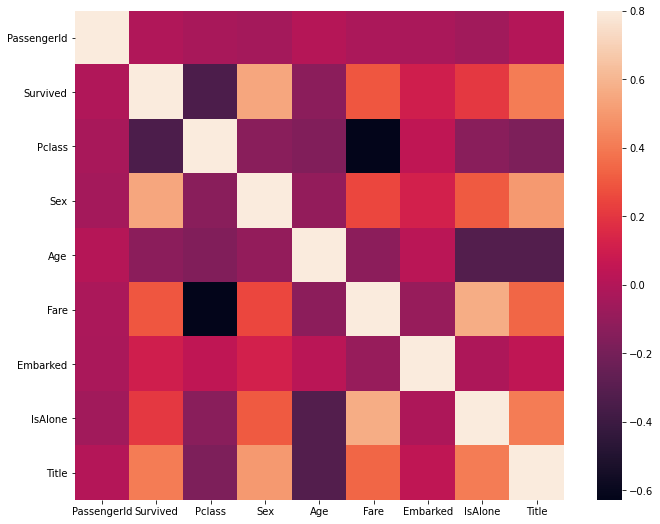

In [203]:
# 相关系数分析
corrmat = train_data.corr()
f,ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat,square=True,vmax=.8)
# 从图上可以看出来,性别和存活有关系

Index(['Survived', 'Sex', 'Title', 'Fare', 'IsAlone', 'Embarked',
       'PassengerId', 'Age', 'Pclass'],
      dtype='object')


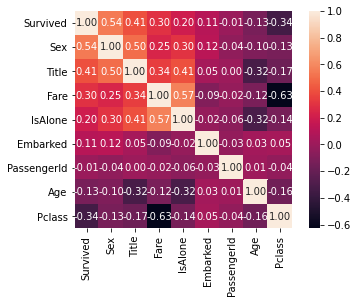

In [204]:
# 选取10个最相关的特征
k = 10
cols = corrmat.nlargest(k,'Survived')['Survived'].index
print(cols)
cm = np.corrcoef(train_data[cols].values.T)
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.2f',annot_kws={'size':10},yticklabels=cols.values,xticklabels=cols.values)

In [205]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  891 non-null    int64
 1   Survived     891 non-null    int64
 2   Pclass       891 non-null    int64
 3   Sex          891 non-null    int64
 4   Age          891 non-null    int64
 5   Fare         891 non-null    int64
 6   Embarked     891 non-null    int64
 7   IsAlone      891 non-null    int64
 8   Title        891 non-null    int64
dtypes: int64(9)
memory usage: 62.8 KB


In [206]:
# 删除没用的数据
y_train,X_train = train_data['Survived'].values,train_data.drop(['PassengerId','Survived'],axis=1).values

X_test = test_data.drop(['PassengerId'],axis=1).values

In [207]:
# 构建最好参数的模型
scoring = make_scorer(accuracy_score, greater_is_better=True)

def get_model(estimator, parameters, X_train, y_train, scoring): 
    # parameters['random_state'] =[0]
    model = GridSearchCV(estimator, param_grid=parameters, scoring=scoring)
    model.fit(X_train, y_train)
    return model.best_estimator_

In [208]:
# 打印学习曲线
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    plt.figure(figsize=(10,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring,
                                                            n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [209]:
# 模型
models = {
    'KNN':KNeighborsClassifier(),
    'RFC':RandomForestClassifier(),
    'SVC':SVC(),
    'DTC':DecisionTreeClassifier(),
    'ADBC':AdaBoostClassifier()
}

# 搜索的参数
parameters = {
    'KNN':{
        'n_neighbors':[i for i in range(2,15)],
        'p':[1,2],
        'weights':['uniform']
    },
    'RFC':{
        'n_estimators':np.linspace(20,200,6,dtype=np.int),
    },
    'SVC':{
         'kernel':['linear','rbf'], # 核
    },
    'DTC':{
        'criterion':['gini','entropy'], # gini:基尼系数 entropy:信息熵
        'splitter':['best'], # 样本不大用best,大用random
        'max_depth':range(1,10,1) # 树的深度,样本和特征少,深度小点,解决过拟合
    },
    'ADBC':{
        'base_estimator':[DecisionTreeClassifier()], # 基分类器
        'n_estimators':[30,50,80,100], # 基分类器提升（循环）次数,默认是50次，这个值过大，模型容易过拟合；值过小，模型容易欠拟合
        'learning_rate':[.5,1,1.3], # 学习率
    },
}

KNN {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}
----------------------------------------
RFC {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 164, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
----------------------------------------
SVC {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
----------------------------------------
DTC {'ccp_alpha

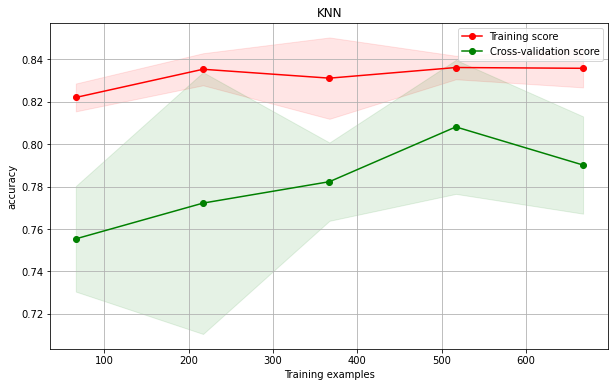

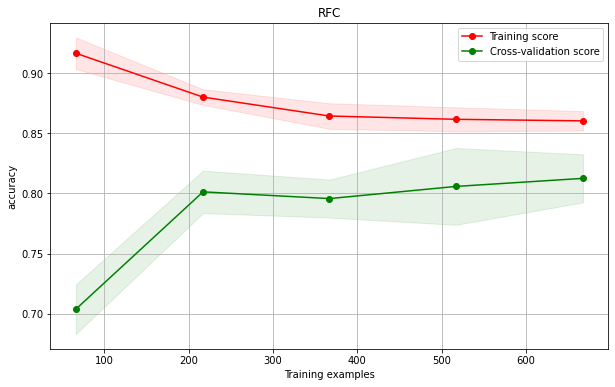

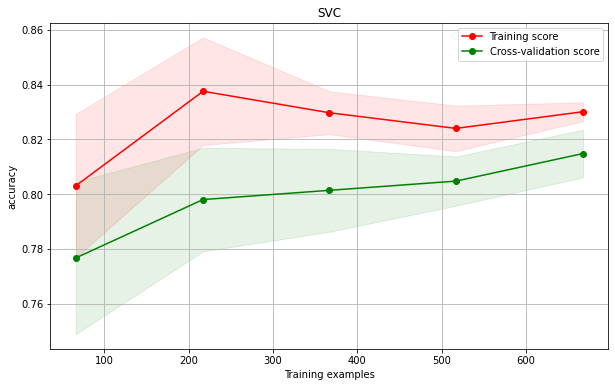

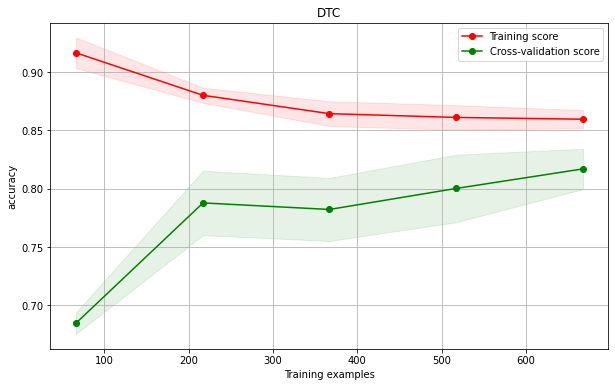

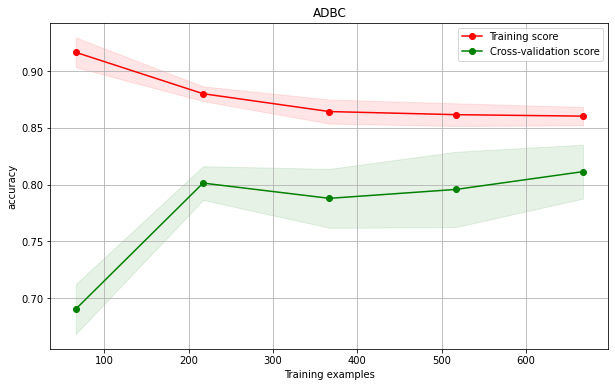

In [210]:
# 训练模型
best_models = []
for k,v in models.items():
    best_model = get_model(v,parameters=parameters[k],X_train=X_train,y_train=y_train,scoring=scoring)
    print(k,best_model.get_params())
    print('-'*40)
    best_models.append((k,best_model))
    plot_learning_curve(best_model, k, X_train, y_train, cv=4)

In [211]:
# 把几个分类器集成起来
clf_vc = VotingClassifier(estimators=best_models,
                          voting='hard')
clf_vc = clf_vc.fit(X_train, y_train)



In [212]:
# 预测
pred = clf_vc.predict(X_test)

In [213]:
# 生成预测文件
pred_data = pd.DataFrame({'PassengerId':test_data.PassengerId,'Survived':pred})

pred_data.to_csv("../data/titanic/submission.csv",index=False)
print('保存完成')

保存完成
